In [ ]:
# Зависимости
!pip install --upgrade pandas==1.4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.7 MB 5.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
import numpy as np
import pandas as pd
from typing import Callable, Tuple

from sklearn.model_selection import train_test_split

%pylab inline
plt.style.use('bmh')

Populating the interactive namespace from numpy and matplotlib


# 1. Синтетические данные
* Сгенерируйте различные линейные, полиномиальные и другие зависимости отличные от тех, что в примере(как минимум 3 поднабора).
* Проверьте как с этими наборами справятся полиномы различной степени и разные типы регуляризации (для каждого набора проверьте как минимум по 2 модели).


## 1.1 Заголовок, скрывающий функции из ознакомительного блокнота

In [ ]:
def vis_data(x_train, x_test, y_train, y_test, gen_func, title, ax, alpha=1.):
  plt.rcParams.update({"font.size": 15})
  start_x = min(min(x_train), min(x_test))
  stop_x = max(max(x_train), max(x_test))
  true_x = np.linspace(start_x, stop_x, num=500)
  ax.scatter(x_train, y_train, label="Тренировочные данные", alpha=alpha)
  ax.scatter(x_test, y_test, label="Тестовые данные", alpha=alpha)
  ax.plot(true_x, [gen_func(x) for x in true_x], label="Порождающая функция", alpha=alpha)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.legend(loc="best")
  ax.set_title(title)
  return ax

class LinearRegression():
    def __init__(self,
                 learning_rate = 0.5,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        self.val_cost= np.zeros(epochs) #add validation

        self.n_batches = n_batches

        if not(self.weights is None) and (self.bias):
          if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias, self.weights)

    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)

    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size

    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size

    #---------------------------------
    def update(self):
        return self.weights - self.lr*self.grad

    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()

    #---------------------------------
    def score(self, X, y):
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

    #---------------------------------
    def fit(self, X, y, X_test, y_test):
        # Add validation for early stop

        if self.weights is None:
            self.weights = self.init(X.shape[1])

        if self.bias is None:
            self.bias    = self.init(1)

        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)

        self.best_weights = self.weights[:] # track best weights
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:
            self.batch_size = y.size

        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size

        best_score = 100.
        for i in range(self.epochs):
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)):

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch)
                self.weights = self.update()
                loss += self.loss(yhat,  y_batch)
                if cnt>= self.n_batches:
                    break

            self.cost[i] = loss / self.n_batches

            # val batches
            val_loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X_test, y_test)):
                yhat = self.forward(x_batch)
                val_loss += self.loss(yhat,  y_batch)
                if cnt >= self.n_batches:
                    break

            self.val_cost[i] = val_loss / (cnt + 1)
            if best_score > self.val_cost[i]:
              self.best_weights = self.weights[:]

        # restore best weights
        self.weights = self.best_weights[:]
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch

    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

class ElasticRegression(LinearRegression):
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

    #---------------------------------
    def loss(self,yhat, y):
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term

    #---------------------------------
    def update(self):
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

## 1.2. Свои наборы данных

In [ ]:
class DataGenerator1D:
  def __init__(
      self, true_func: Callable[[None], float], balanced: bool=False, borders: Tuple[int, int]=(-5, 5)
    ) -> None:
    """Class init
    :param true_func: function for data generation
    :param num: number of observations
    :param balanced: if True data was uniformal distribution between borders
    :param borders: tuple with borders for all dims
    """
    self.gen_func = true_func
    self.borders = borders
    self.balanced = balanced

  def generate_dataset(self, num: int=250, noise_amplitude=1.):
    """Generate dataset
    :param num: number of samples
    :noise_amplitude: float, that mean absolute of amplitude of [multiplicative] noise
    """
    if self.balanced:
      idx = np.linspace(self.borders[0], self.borders[1], num=num)
    else:
      idx = np.random.choice(
          [x for x in np.linspace(self.borders[0], self.borders[1], num=num * 5)], num, replace=False
      )
    data = np.array([self.gen_func(x) for x in idx])
    data += np.random.randn(len(data)) * noise_amplitude
    X_train, X_test, y_train, y_test = train_test_split(idx, data, test_size=0.2)
    return X_train, X_test, y_train, y_test

class DataGeneratorND(DataGenerator1D):
  def __init__(self, true_func: Callable[[None], float], balanced: bool=False, borders: Tuple[int, int]=(-5, 5)):
    super().__init__(true_func, balanced, borders)

  def generate_dataset(self, ndims=2, num: int=250, noise_amplitude=1.):
    """Generate dataset
    :param: number of dims of X
    :param num: number of samples
    :noise_amplitude: float, that mean absolute of amplitude of [multiplicative] noise
    """
    if self.balanced:
      idx = []
      for dim in range(ndims):
        idx.append(np.linspace(self.borders[0], self.borders[1], num=num))
    else:
      for dim in range(ndims):
        idx.append(np.random.choice(
            [x for x in np.linspace(self.borders[0], self.borders[1], num=num * 5)], num, replace=False
        ))
    data = np.array([self.gen_func(x) for x in idx])
    data += np.random.randn(len(data)) * noise_amplitude
    X_train, X_test, y_train, y_test = train_test_split(idx, data, test_size=0.2)
    return X_train, X_test, y_train, y_test

In [ ]:
# 1. кусочно-линейная функция
def relu(x):
  if x > 0:
    return (x)
  else:
    return (x) * 0.25

# 2. Нормльный колокол
def normal_curve(x):
  return 1 / np.sqrt(np.pi * 2.) * np.exp(-.5 * x ** 2)

# 3. Экспоненциальный спад
def negative_exp(x):
  return np.exp(-0.25 * (x * 10)) * np.sin(x * 10) / (x * 10)

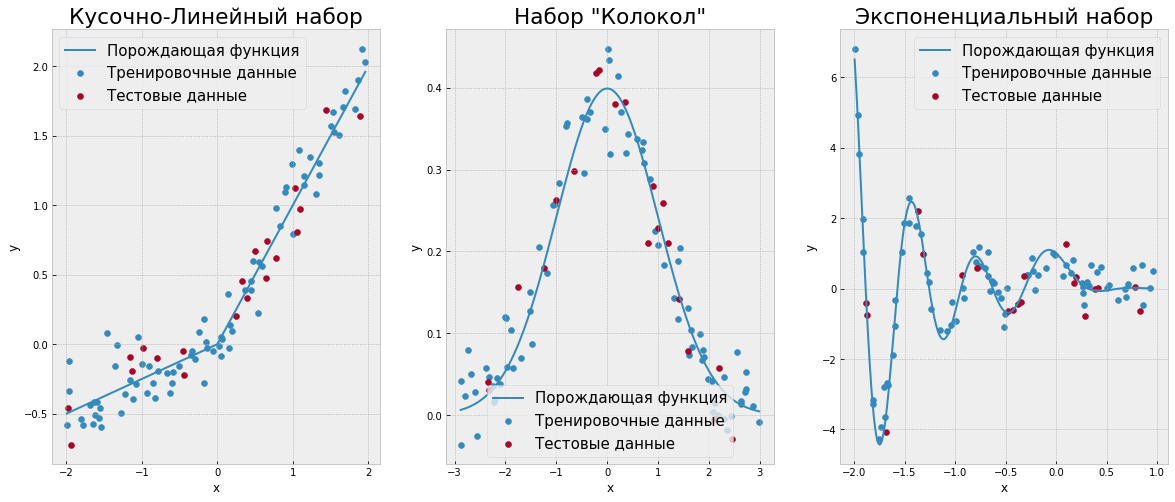

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
a = DataGenerator1D(relu, balanced=False, borders=(-2, 2))
X_train, X_test, y_train, y_test = a.generate_dataset(100, noise_amplitude=.15)
vis_data(X_train, X_test, y_train, y_test, relu, "Кусочно-Линейный набор", ax=ax[0])
a = DataGenerator1D(normal_curve, balanced=False, borders=(-3, 3))
X_train, X_test, y_train, y_test = a.generate_dataset(100, noise_amplitude=.035)
vis_data(X_train, X_test, y_train, y_test, normal_curve, "Набор \"Колокол\"", ax=ax[1])
a = DataGenerator1D(negative_exp, balanced=False, borders=(-2, 1))
X_train, X_test, y_train, y_test = a.generate_dataset(100, noise_amplitude=.35)
vis_data(X_train, X_test, y_train, y_test, negative_exp, "Экспоненциальный набор", ax=ax[2])
plt.show()

Наборы данных сформированы неравномерно - существует скопления точек и области, где точек мало. Так же большие значения менее подвержены шуму чем маленькие (особенности генерации). Наборы данных:
* Кусочно-линейный - состоит из двух линеных зависимостей с различными углами наклона относительно координат.
* Набор "Колокол" - представляет собой нелинейную, непереодическую функцию.
* Экспоненциально затухающй синус - состоит из переодической компоненты и экспоненциального затухания.

## 1.3 Как справится с данными регрессия
1. Кусочно-линейный набор
2. Набор "Колокол"
2. Экспоненциально затухающй синус

В данном разделе я решил автоматизировать поиск лучшего решения (изобрести велосипед - grid search). В нем же будут учтены комбинации признаков (полиноминальные).

In [ ]:
# вывод прогресбара
from tqdm.notebook import tqdm
# сохранение метрик
import pandas as pd
# комбинаторика
import itertools
# в базовом классе нет проверки на бесконечность при умножении
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
class GridSearch:
  def __init__(self, search_params, train_x, test_x, train_y, test_y):
    self.train_x = train_x
    self.test_x = test_x
    self.train_y = train_y
    self.test_y = test_y
    self.parameters_table = pd.DataFrame(columns="learning_rate,epochs,batch_size,polynom_order,l1_penalty,l2_penalty,best_val_score,best_train_score,best_iter".split(","))
    self.history_dump = []
    self.weights_dump = []
    self.best_classifier = None
    self.best_order = None

    _keys, _values = zip(*search_params.items())
    self.grid_points = [dict(zip(_keys, v)) for v in itertools.product(*_values)]
    print(f"Have {len(self.grid_points)} points in hyperparameters space to search")

  def fit(self):
    for params in tqdm(self.grid_points):
      polynom_order = params.pop('polynom_order')
      self._one_round(params, polynom_order)

  def _one_round(self, regression_params, polynom_order):
    # palce params to frame
    self.parameters_table = self.parameters_table.append(regression_params, ignore_index=True)
    self.parameters_table.iloc[-1]["polynom_order"] = polynom_order
    # apply polynominal
    if polynom_order:
      train = self._to_polynom(self.train_x[:, 0], polynom_order)
      test = self._to_polynom(self.test_x[:, 0], polynom_order)
      for dim in range(1, self.train_x.shape[1]):
        train = np.hstack([train, self._to_polynom(self.train_x[:, dim], polynom_order)])
        test = np.hstack([test, self._to_polynom(self.test_x[:, 0], polynom_order)])
    else:
      train = self.train_x.copy()
      test = self.train_x.copy()
    # construct solver
    temp_reg = ElasticRegression(**regression_params)
    temp_reg.fit(train, self.train_y, test, self.test_y)
    self.history_dump.append((temp_reg.cost, temp_reg.val_cost))
    self.weights_dump.append(temp_reg.weights)
    # save best classifier
    best_val_score = min(temp_reg.val_cost)
    if self.best_classifier is None:
      self.best_classifier = temp_reg
      self.best_order = polynom_order
    if self.parameters_table["best_val_score"].min() > best_val_score:
      self.best_classifier = temp_reg
      self.best_order = polynom_order
    # compute best iter and score
    self.parameters_table.iloc[-1]["best_train_score"] = min(temp_reg.cost)
    self.parameters_table.iloc[-1]["best_val_score"] = best_val_score
    self.parameters_table.iloc[-1]["best_iter"] = np.argmin(np.array(temp_reg.val_cost))

  def _to_polynom(self, x, order=1, add_bias=False):
    order_range = range( 0 if add_bias else 1, order + 1 ,1)
    x = np.atleast_1d(x)[:]
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T

  def predict(self, X):
    if self.best_order:
      x = self._to_polynom(X[:, 0], self.best_order)
      for dim in range(1, X.shape[1]):
        x = np.hstack([x, self._to_polynom(X[:, dim], self.best_order)])
    else:
      x = X.copy()
    return self.best_classifier.predict(x)

Для использования класса необходимо задать область поиска через словарь со списками:

```python
search_grid = {
    "learning_rate": [0.001],
    "epochs": [300],
    "batch_size": [10],
    "l1_penalty": [0.0001],
    "l2_penalty": [0.001],
    "polynom_order": [3]
}
```
В словаре выше приведен минимальный пример. Если полиномы не нужны, то `polynom_order` выставляется в None.

Поищем решение для трех одномерных датасетов.




###1. Кусочно-линейный

При его инициализации указал `balanced=False`, при этом генератор будет генерировать точки не равномерно относительно всего отрезка (будут появлятся скопления точек).

In [ ]:
dataset = DataGenerator1D(relu, balanced=False, borders=(-2, 2))
X_train, X_test, y_train, y_test = dataset.generate_dataset(100, noise_amplitude=.15)

In [ ]:
search_grid = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.],
    "epochs": [1500], # Можем ставить максимум, переберать смысла нет - трек валидации внутри поисковика, по нему можно отследить
    "batch_size": [50], # Не перебирал, т.к. сильно замедляют
    "l1_penalty": [0.0001, 0.001, 0.01, 0.1],
    "l2_penalty": [0.0001, 0.001, 0.01, 0.1],
    "polynom_order": [None, 0, 1, 2, 3, 4]
}
g_search = GridSearch(search_grid, X_train.reshape((-1, 1)), X_test.reshape((-1, 1)), y_train.reshape((-1, 1)), y_test.reshape((-1, 1)))

Have 480 points in hyperparameters space to search


In [ ]:
g_search.fit()
print("Лучшие параметры:")
g_search.parameters_table[g_search.parameters_table["best_val_score"] == g_search.parameters_table["best_val_score"].min()].iloc[:1]

  0%|          | 0/480 [00:00<?, ?it/s]

Лучшие параметры:


,learning_rate,epochs,batch_size,polynom_order,l1_penalty,l2_penalty,best_val_score,best_train_score,best_iter
291,0.1,1500.0,50.0,2.0,0.0001,0.0001,0.018778,0.0627,1421.0


In [ ]:
def grid_vis(grid):
  best = grid.parameters_table["best_val_score"].sort_values(ascending=True).index[0]
  fig, ax = plt.subplots(1, figsize=(20, 8))
  ax.plot(grid.history_dump[best][0], label="Train score")
  ax.plot(grid.history_dump[best][1], label="Val score")
  ax.axvline(np.argmin(np.array(grid.history_dump[best][0])), color="black", label="Best iter")
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Score (log scale)")
  ax.set_title("Grid search results")
  ax.set_yscale("log")
  ax.legend(loc="best")
  plt.show()
  return

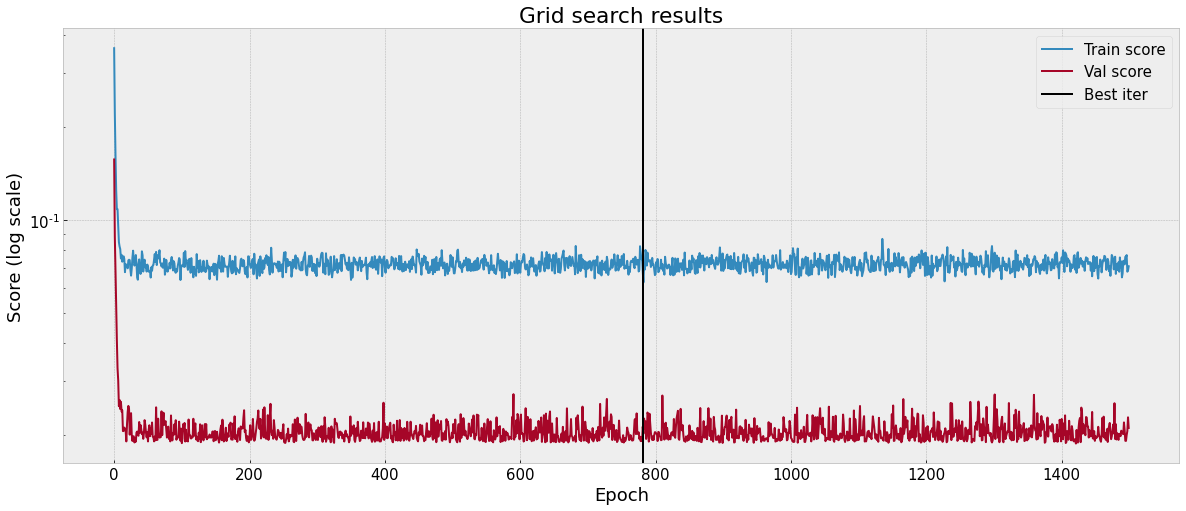

In [ ]:
grid_vis(g_search)

Востанавливаем регрессию

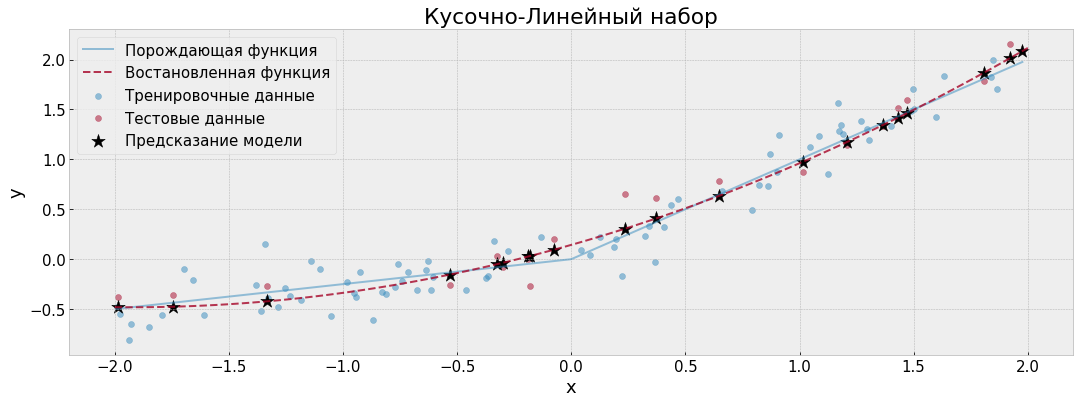

In [ ]:
fig, ax = plt.subplots(1, figsize=(18, 6))
vis_data(X_train, X_test, y_train, y_test, relu, "Кусочно-Линейный набор", ax=ax, alpha=0.5)
model_predicts_test = g_search.predict(X_test.reshape((-1, 1)))
ax.scatter(X_test, model_predicts_test, s=200, marker="*", color="black", label="Предсказание модели")
new_x = np.linspace(-2, 2, num=100)
model_predicts_func = g_search.predict(new_x.reshape((-1, 1)))
ax.plot(new_x, model_predicts_func, linestyle="--", label="Востановленная функция", alpha=.8)
ax.legend(loc="best")
plt.show()

Видно, что на концах отрезка начинаются искревления, однако на средней части регрессия ведет себя удовлетворительно.

###2. Колокол.

При его инициализации указал `balanced=False`, при этом генератор будет генерировать точки не равномерно относительно всего отрезка (будут появлятся скопления точек).

Have 800 points in hyperparameters space to search


  0%|          | 0/800 [00:00<?, ?it/s]

Лучшие параметры:
     learning_rate  epochs  batch_size  polynom_order  l1_penalty  l2_penalty  \
165          0.001  1500.0        50.0            4.0      0.0001      0.0001   

     best_val_score  best_train_score  best_iter  
165        0.002609           0.00421     1499.0  


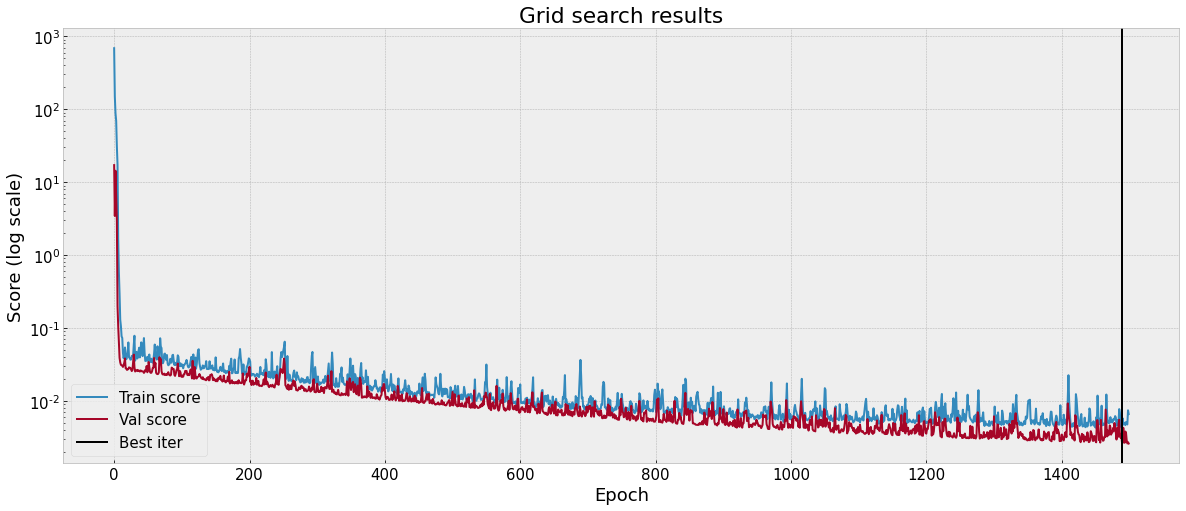

In [ ]:
dataset_normal = DataGenerator1D(normal_curve, balanced=False, borders=(-3, 3))
X_train, X_test, y_train, y_test = dataset_normal.generate_dataset(100, noise_amplitude=.035)
search_grid = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.],
    "epochs": [1500], # Можем ставить максимум, переберать смысла нет - трек валидации внутри поисковика, по нему можно отследить
    "batch_size": [50], # Не перебирал, т.к. сильно замедляют
    "l1_penalty": [0.0001, 0.001, 0.01, 0.1],
    "l2_penalty": [0.0001, 0.001, 0.01, 0.1],
    "polynom_order": [None, 0, 1, 2, 3, 4, 5, 6, 10, 20]
}
g_search = GridSearch(search_grid, X_train.reshape((-1, 1)), X_test.reshape((-1, 1)), y_train.reshape((-1, 1)), y_test.reshape((-1, 1)))
g_search.fit()
print("Лучшие параметры:")
print(g_search.parameters_table[g_search.parameters_table["best_val_score"] == g_search.parameters_table["best_val_score"].min()].iloc[:1])
grid_vis(g_search)

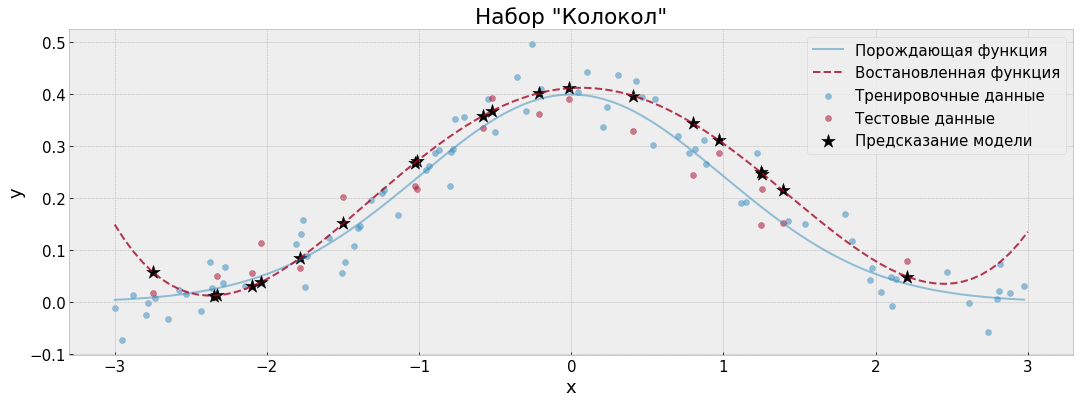

In [ ]:
fig, ax = plt.subplots(1, figsize=(18, 6))
vis_data(X_train, X_test, y_train, y_test, normal_curve, "Набор \"Колокол\"", ax=ax, alpha=0.5)
model_predicts_test = g_search.predict(X_test.reshape((-1, 1)))
ax.scatter(X_test, model_predicts_test, s=200, marker="*", color="black", label="Предсказание модели")
new_x = np.linspace(-3, 3, num=100)
model_predicts_func = g_search.predict(new_x.reshape((-1, 1)))
ax.plot(new_x, model_predicts_func, linestyle="--", label="Востановленная функция", alpha=.8)
ax.legend(loc="best")
plt.show()

Найденная регрессия хорошо описывает истинную зависимость по данным, однако имеет сильное расхождения на границах (в области $-3$ и $3$). Модель можно использовать при условии того, что фича не выйдет за диапозон $[-3, 3]$.


###3. Экспоненциальный

При его инициализации указал `balanced=False`, при этом генератор будет генерировать точки не равномерно относительно всего отрезка (будут появлятся скопления точек).

Have 800 points in hyperparameters space to search


  0%|          | 0/800 [00:00<?, ?it/s]

Лучшие параметры:
     learning_rate  epochs  batch_size  polynom_order  l1_penalty  l2_penalty  \
167          0.001  1500.0        50.0            6.0      0.0001      0.0001   

     best_val_score  best_train_score  best_iter  
167        1.714209          3.801479       43.0  


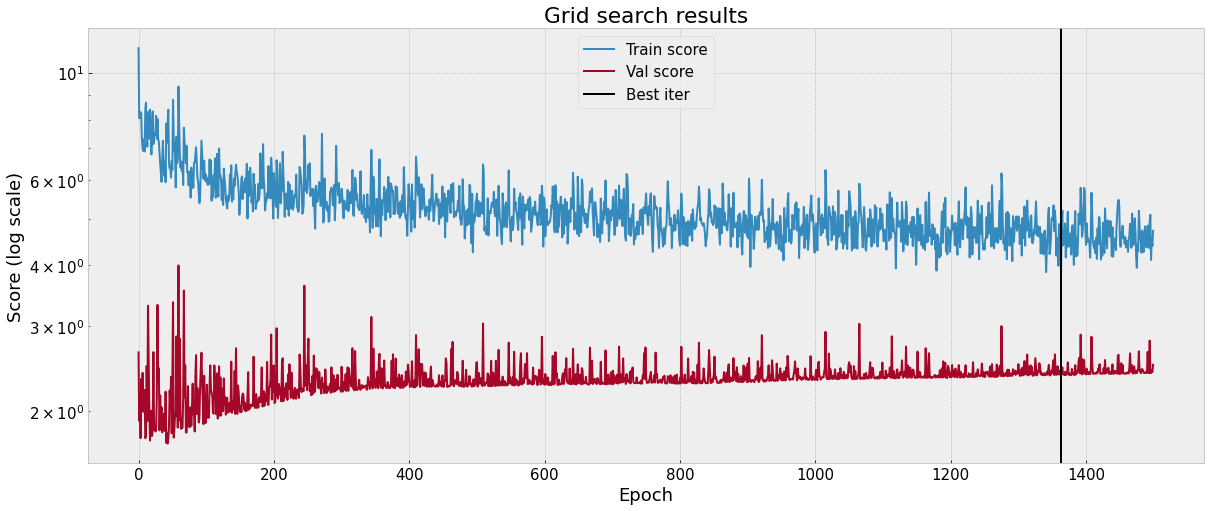

In [ ]:
dataset_exp = DataGenerator1D(negative_exp, balanced=False, borders=(-2, 1))
X_train, X_test, y_train, y_test = dataset_exp.generate_dataset(100, noise_amplitude=.35)
search_grid = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.],
    "epochs": [1500], # Можем ставить максимум, переберать смысла нет - трек валидации внутри поисковика, по нему можно отследить
    "batch_size": [50], # Не перебирал, т.к. сильно замедляют
    "l1_penalty": [0.0001, 0.001, 0.01, 0.1],
    "l2_penalty": [0.0001, 0.001, 0.01, 0.1],
    "polynom_order": [None, 0, 1, 2, 3, 4, 5, 6, 10, 20]
}
g_search = GridSearch(search_grid, X_train.reshape((-1, 1)), X_test.reshape((-1, 1)), y_train.reshape((-1, 1)), y_test.reshape((-1, 1)))
g_search.fit()
print("Лучшие параметры:")
print(g_search.parameters_table[g_search.parameters_table["best_val_score"] == g_search.parameters_table["best_val_score"].min()].iloc[:1])
grid_vis(g_search)

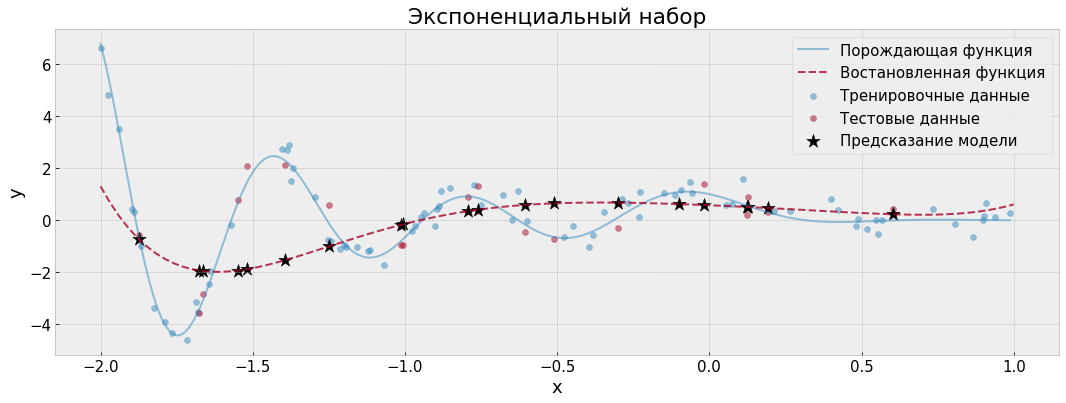

In [ ]:
fig, ax = plt.subplots(1, figsize=(18, 6))
vis_data(X_train, X_test, y_train, y_test, negative_exp, "Экспоненциальный набор", ax=ax, alpha=0.5)
model_predicts_test = g_search.predict(X_test.reshape((-1, 1)))
ax.scatter(X_test, model_predicts_test, s=200, marker="*", color="black", label="Предсказание модели")
new_x = np.linspace(-2, 1, num=100)
model_predicts_func = g_search.predict(new_x.reshape((-1, 1)))
ax.plot(new_x, model_predicts_func, linestyle="--", label="Востановленная функция", alpha=.8)
ax.legend(loc="best")
plt.show()

Не получилось подобрать достаточно хорошую линейную модель под такой тип зависимости данных.

Немного читов, внесем переодические термы в данные

$$x^{new}=\begin{bmatrix}
    x_{1} & sin(x_{1}) & cos(x_{1}) \\
    x_{2} & sin(x_{2}) & cos(x_{2}) \\
    \dots & \dots & \dots \\
    x_{d} & sin(x_{d}) & cos(x_{d})
\end{bmatrix}$$

In [ ]:
periodic = lambda x: np.hstack((x, np.sin(x), np.cos(x)))

class GridSearchPeriodic(GridSearch):
  def __init__(self, search_params, train_x, test_x, train_y, test_y):
    super().__init__(search_params, train_x, test_x, train_y, test_y)

  def _to_polynom(self, x, order=1, add_bias=False):
    order_range = range( 0 if add_bias else 1, order + 1 ,1)
    x = np.atleast_1d(x)[:]
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    out = out.reshape(-1, x.size).T
    out_pereodic = periodic(out[:, 0].reshape((-1, 1)))
    for dim in range(1, out.shape[1]):
      out_pereodic = np.hstack([out_pereodic, periodic(out[:, dim].reshape((-1, 1)))])
    return out_pereodic

Have 800 points in hyperparameters space to search


  0%|          | 0/800 [00:00<?, ?it/s]

Лучшие параметры:
     learning_rate  epochs  batch_size  polynom_order  l1_penalty  l2_penalty  \
325           0.01  1500.0        50.0            4.0      0.0001      0.0001   

     best_val_score  best_train_score  best_iter  
325        0.423344          0.952453     1299.0  


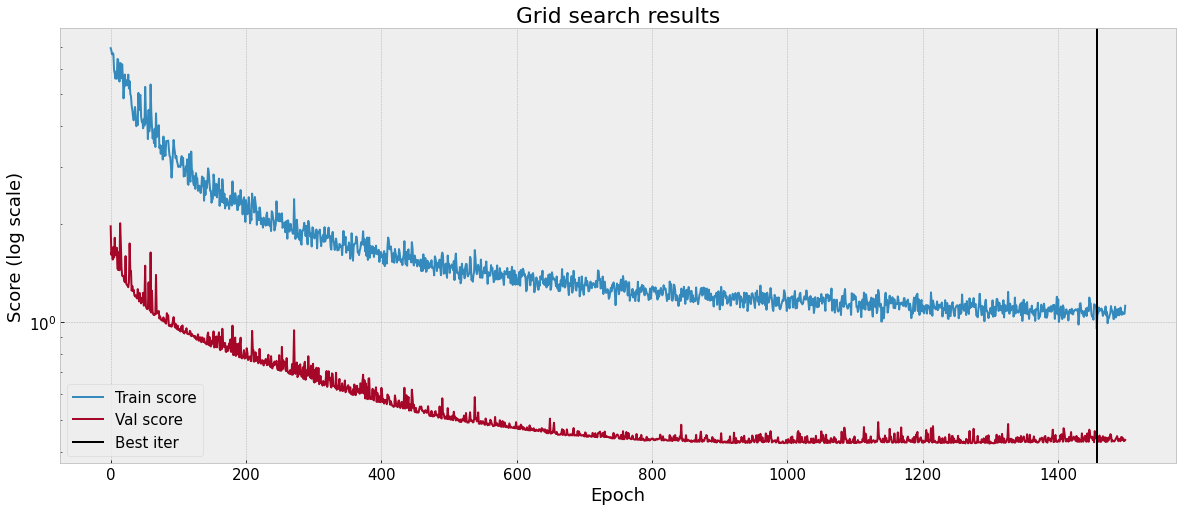

In [ ]:
g_search = GridSearchPeriodic(search_grid, X_train.reshape((-1, 1)), X_test.reshape((-1, 1)), y_train.reshape((-1, 1)), y_test.reshape((-1, 1)))
g_search.fit()
print("Лучшие параметры:")
print(g_search.parameters_table[g_search.parameters_table["best_val_score"] == g_search.parameters_table["best_val_score"].min()].iloc[:1])
grid_vis(g_search)

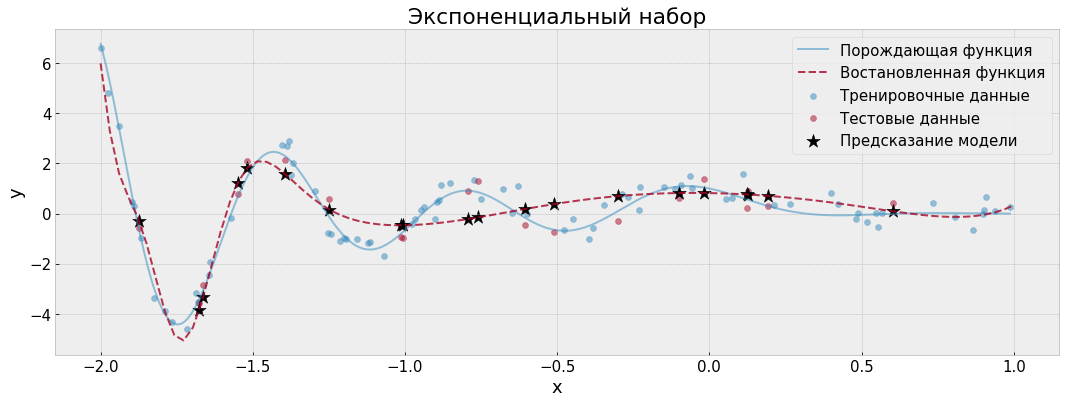

In [ ]:
fig, ax = plt.subplots(1, figsize=(18, 6))
vis_data(X_train, X_test, y_train, y_test, negative_exp, "Экспоненциальный набор", ax=ax, alpha=0.5)
model_predicts_test = g_search.predict(X_test.reshape((-1, 1)))
ax.scatter(X_test, model_predicts_test, s=200, marker="*", color="black", label="Предсказание модели")
new_x = np.linspace(-2, 1, num=100)
model_predicts_func = g_search.predict(new_x.reshape((-1, 1)))
ax.plot(new_x, model_predicts_func, linestyle="--", label="Востановленная функция", alpha=.8)
ax.legend(loc="best")
plt.show()

Внесение переодических термов сильно улучшило модель, однако остается вопрос - применим ли такой подход на практике? Скорее всего, он будет неплох при предсказании на данных, в которых присутсвуб сезонные изменения.

# 2. Для набора данных Cars Moldova

* Cкачайте набор данных Cars Moldova (сразу очищенных от дубликатов и выбросов, лучше с добавленными признаками из «Задания 1»).
* Используйте любую из подготовленных вами моделей линейной регрессии для предсказания цены автомобилей на вторичном рынке Молдавии. Оцените модель на отложенной выборке.
* Оцените влияние разных типов предварительной обработки на результат (использование стандартизации, нормализации или степенного преобразования для числовых признаков).
* Сравните результаты модели при использовании только числовых признаков и при добавлении категориальных признаков с помощью one-hot кодирования.
Оцените наиболее значимые признаки для модели проанализировав веса.

План:
1. Загрузка данных
2. Поиск лучшей модели для каждого набора
3. Анализ метрик



###1. Загрузка Данных

Разобъем датасет на `train`, `validation` и `test` для того чтобы не допустить переобучения на `train` (оценка по `validation`) и проверить итоговую модель на отложенных данных (`test`).

In [ ]:
import pandas as pd
import pickle
import os

In [ ]:
pd_url = lambda url: 'https://drive.google.com/uc?id=' + url.split('/')[-2]

In [ ]:
url_std_onehot = 'https://drive.google.com/file/d/1flC3-E5p6KpV8p_PyhiwxasU5tZZ-8L7/view?usp=share_link'
url_power_onehot = 'https://drive.google.com/file/d/183PQt28qLymtjVllNb-sRm_2zrbKatWV/view?usp=share_link'
url_norm_onehot = 'https://drive.google.com/file/d/1p9JrNYwprl0NQfkFTdwe7iRQaJl59NlJ/view?usp=share_link'

url_std_ordinal = 'https://drive.google.com/file/d/1rvJUxtZOgfuiY6e6GJA93Hg-lNT7UCVM/view?usp=share_link'
url_power_ordinal = 'https://drive.google.com/file/d/12a8Majne9vkOtPZxcKJPfa-rcprglA90/view?usp=share_link'
url_norm_ordinal = 'https://drive.google.com/file/d/1lYf2BWm9_15ZvCgeaOT5NU9xXHt6-czN/view?usp=share_link'

In [ ]:
data_std_onehot = pd.read_csv(pd_url(url_std_onehot))
data_power_onehot = pd.read_csv(pd_url(url_power_onehot))
data_norm_onehot = pd.read_csv(pd_url(url_norm_onehot))
data_std_ordinal = pd.read_csv(pd_url(url_std_ordinal))
data_power_ordinal = pd.read_csv(pd_url(url_power_ordinal))
data_norm_ordinal = pd.read_csv(pd_url(url_norm_ordinal))
print("Загружены все наборы данных [предобработаные]")

Загружены все наборы данных [предобработаные]


Поместим датасеты в словарь для удобства взаимодействия

In [ ]:
data = {
  "data_std_onehot": data_std_onehot,
  "data_power_onehot": data_power_onehot,
  "data_norm_onehot": data_norm_onehot,
  "data_std_ordinal": data_std_ordinal,
  "data_power_ordinal": data_power_ordinal,
  "data_norm_ordinal": data_norm_ordinal
}

In [ ]:
# Проверяем, есть ли прошлая разбивка
if "train_idx.pkl" in os.listdir():
  train_idx = pickle.load(open("./train_idx.pkl", "rb"))
  val_idx = pickle.load(open("./val_idx.pkl", "rb"))
  test_idx = pickle.load(open("./test_idx.pkl", "rb"))
  print(f"Restore data splits from disk\n\t{'Train':15s}: {len(train_idx)}\n\t{'Validation':15s}: {len(val_idx)}\n\t{'Test':15s}: {len(test_idx)}")
else:
  # Получение индексов
  _all_idx = [x for x in range(len(data_std_onehot))]
  # 80% на обучение
  train_idx = np.random.choice(_all_idx, int(len(_all_idx) * .8), replace=False).tolist()
  # 10% на валидацию
  val_idx = np.random.choice(list(set(_all_idx) - set(train_idx)), int((len(_all_idx) - len(train_idx)) * .5), replace=False).tolist()
  # 10% на валидацию
  test_idx = list(set(_all_idx) - set(train_idx) - set(val_idx))
  del _all_idx
  pickle.dump(train_idx, open("./train_idx.pkl", "wb"))
  pickle.dump(val_idx, open("./val_idx.pkl", "wb"))
  pickle.dump(test_idx, open("./test_idx.pkl", "wb"))
  print(f"Data splits\n\t{'Train':15s}: {len(train_idx)}\n\t{'Validation':15s}: {len(val_idx)}\n\t{'Test':15s}: {len(test_idx)}")

Restore data splits from disk
	Train          : 25776
	Validation     : 3222
	Test           : 3222


###2. Поиск лучшей модели

Для трека откликов будут записываться истинные значения и предсказание моделей для каждого набора данных (чтобы в дальнейшем посчитать метрики полученных моделей).

In [ ]:
# Параметры сетки поиска
search_grid = {
    "learning_rate": [0.01, 0.1],
    "epochs": [1500], # Можем ставить максимум, переберать смысла нет - трек валидации внутри поисковика, по нему можно отследить
    "batch_size": [3222], # Не перебирал, т.к. сильно замедляют
    "l1_penalty": [0.001, 0.01, 0.1],
    "l2_penalty": [0.001, 0.01, 0.1],
    "polynom_order": [None, 1, 2] # поменьше полиномов - экономим :)
}

In [ ]:
# Костыль для продолжения (Colab любит внезапно сессию закончить)
START_FROM = 0

In [ ]:
models_predictions_frame = dict()
for idx, (k, v) in enumerate(data.items()):
  if idx < START_FROM:
    continue
  print("=" * 5 + f" {k} " + "=" * 5)
  # Получаем колонки
  target = "Price(euro)"
  features = [x for x in v.columns if x != target]

  # Получаем наборы данных
  X_train, y_train = v.iloc[train_idx][features].values, v.iloc[train_idx][target].values.reshape((-1, 1))
  X_val, y_val = v.iloc[val_idx][features].values, v.iloc[val_idx][target].values.reshape((-1, 1))
  X_test, y_test = v.iloc[test_idx][features].values, v.iloc[test_idx][target].values.reshape((-1, 1))

  # Фитим поиск
  g_search = GridSearch(search_grid, X_train, X_val, y_train, y_val)
  g_search.fit()

  # Дамп ответа и динамики обучения
  model_predicts_train = g_search.predict(X_train)
  model_predicts_val = g_search.predict(X_val)
  model_predicts_test = g_search.predict(X_test)
  models_predictions_frame[k] = {
      "train": model_predicts_train,
      "val": model_predicts_val,
      "test": model_predicts_test,
      "parameters_table": g_search.parameters_table,
      "history": g_search.history_dump
  }
  # Дампим результаты (что б не переучивать)
  pickle.dump(models_predictions_frame, open(f"experiment_data_{idx}.pkl", "wb"))

===== data_std_onehot =====
Have 54 points in hyperparameters space to search


  0%|          | 0/54 [00:00<?, ?it/s]

>В итоге на своем компьютере пересчитал для 144 точек каждую - слишком часто colab отключался :)

 Сетка:
 ```python
 search_grid = {
        "learning_rate": [0.001, 0.01, 0.1],
        "epochs": [1500],
        "train_batch_size": [25776],
        "eval_batch_size": [3222],
        "l1_penalty": [0.001, 0.01, 0.1, 0.5],
        "l2_penalty": [0.001, 0.01, 0.1, 0.5],
        "polynom_order": [None, 1, 2]
    }
 ```

 >Локальные улучшения:
 * пробовал на `torch` - сильно медленнее, видимо bottleneck в перекидывании с `CPU` на `GPU` - но конкретно не строил профили нагрузки ($-40 \% $ скорости)
 * внес дополнительные параметры в класс регрессии: `train_batch`, `val_batch` - т.к. компьютер помощнее и в трейн влазит весь обучающий набор ($+1400\%$ скорости: $7$ минут против $30$ секунд)
 * пробовал `numba njit` - прироста нет
 * переделана инициализация на нули (для регрессии не нашел объяснения [лучше этого](https://datascience.stackexchange.com/questions/30989/what-are-the-cases-where-it-is-fine-to-initialize-all-weights-to-zero), но решил, что тут "сетевые инициализации" [Хи, uniform, и т. д.] не очень подойдут😊)

In [ ]:
from urllib.request import urlopen
import io

In [ ]:
get_pickle_from_disk = lambda url: pickle.load(io.BytesIO(urlopen(pd_url(url)).read()))

models_predictions_frame = dict()
models_predictions_frame["data_std_onehot"] = get_pickle_from_disk("https://drive.google.com/file/d/1NR8IRvBFNI54sG6pBqzi3svEnHmK5oiH/view?usp=share_link")["data_std_onehot"]   # experiment_data_0.pkl
models_predictions_frame["data_power_onehot"] = get_pickle_from_disk("https://drive.google.com/file/d/1da9PalRjztXJVWH-BRGn2pPoNjyud9_o/view?usp=share_link")["data_power_onehot"]  # experiment_data_1.pkl
models_predictions_frame["data_norm_onehot"] = get_pickle_from_disk("https://drive.google.com/file/d/1K3d3jpPIxh-OsSEsQSZMSz1hP5m4EDkV/view?usp=share_link")["data_norm_onehot"]   # experiment_data_2.pkl
models_predictions_frame["data_std_ordinal"] = get_pickle_from_disk("https://drive.google.com/file/d/1y1ERUKb9hKASJQsYEjk4qKDgNWCXf45t/view?usp=share_link")["data_std_ordinal"]   # experiment_data_3.pkl
models_predictions_frame["data_power_ordinal"] = get_pickle_from_disk("https://drive.google.com/file/d/1lqNcvh3l7GKKYDhA9T152RxE-hzQnH_5/view?usp=share_link")["data_power_ordinal"] # experiment_data_4.pkl
models_predictions_frame["data_norm_ordinal"] = get_pickle_from_disk("https://drive.google.com/file/d/1GMeGoqMol7mlQo6LyduhKfqh30Bm_gqP/view?usp=share_link")["data_norm_ordinal"]  # experiment_data_5.pkl

###3. Анализ метрик

> Сравнение историй обучения (ошибок на итерациях)

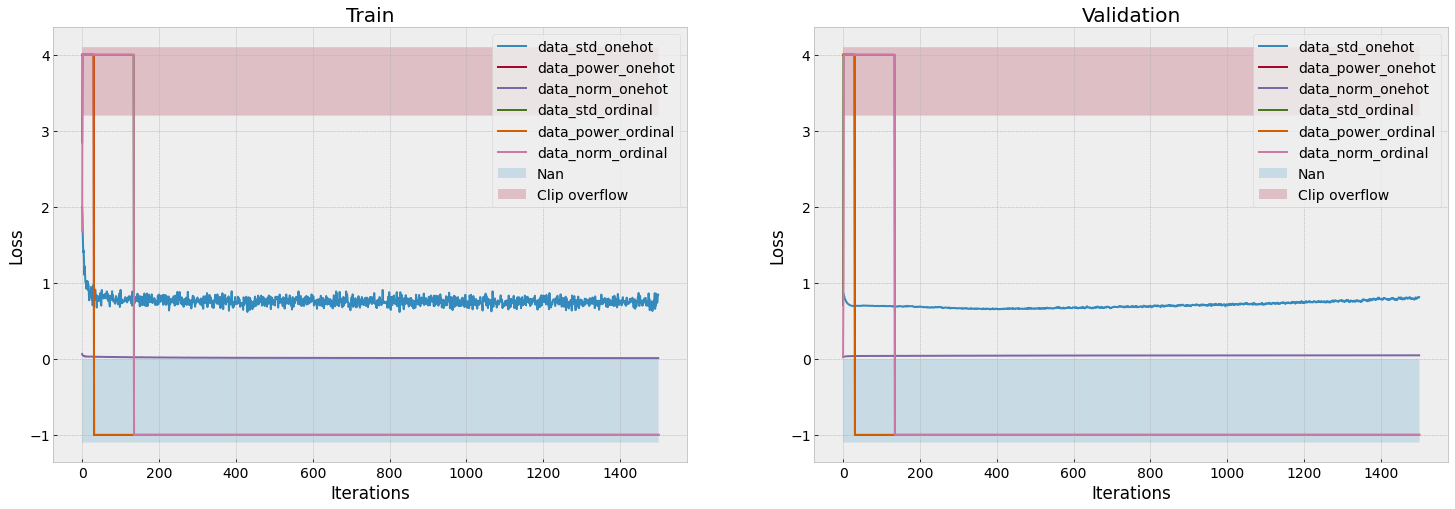

In [ ]:
plt.rcParams.update({"font.size":14})
fig, ax = plt.subplots(1, 2, figsize=(25, 8))
for k, v in models_predictions_frame.items():
    best = v["parameters_table"]["best_val_score"].sort_values(ascending=True).index[0]
    ax[0].plot(np.clip(np.nan_to_num(v["history"][best][0], nan=-1.), -1, 4), label=k)
    ax[1].plot(np.clip(np.nan_to_num(v["history"][best][1], nan=-1.), -1, 4), label=k)
xx = [x for x in range(1501)]
ys = [-1.1 for x in range(1501)]
y_max = [4.1 for x in range(1501)]
y_min = [3.2 for x in range(1501)]
for i in range(2):
    ax[i].set_xlabel("Iterations")
    ax[i].set_ylabel("Loss")
    ax[i].fill_between(xx, ys, interpolate=True, label="Nan", alpha=0.2)
    ax[i].fill_between(xx, y_min, y_max, alpha=0.2, label="Clip overflow")
    ax[i].legend(loc="best")
ax[0].set_title("Train")
ax[1].set_title("Validation")
plt.show()

На графиках присутсвуют 2 области:
* Синяя [Nan] - в нее отображаются все значения `Nan`, полученные при обучении
* Красная [Clip overflow] - срезана ошибка выше $4.0$

Данные области появились из-за неустойчивости обуения некоторых моделей. Например, категориальные данные закодированные способом `ordinal` всегда попадают в эи области. Эффект связан со взрывом градиентов, уменьшение `learning rate` и регуляризация не сильно решает проблему.

Лучшая конфигурация данных: `data_norm_onehot` - нормализация числовых данных и onehot кодирование категориальных.

Ниже приведена таблица с лучшими параметрами для **Elastic Regression**:

In [ ]:
models_predictions_frame["data_norm_onehot"]["parameters_table"].iloc[best: best + 1].drop(columns=["best_weights"])

,learning_rate,epochs,batch_size,polynom_order,l1_penalty,l2_penalty,best_val_score,best_train_score,best_iter,eval_batch_size,train_batch_size
1,0.001,1500.0,NaN,1,0.001,0.001,0.027923,0.027943,1499,3222.0,25776.0


Особенности модели:
* необходим достаточно небольшой `learning rate` (в сетке - `[0.001, 0.01, 0.1]`) - обучловлен тонкой настройкой на целевую переменную (с большим `lr` не сходится).
* степенное преобразование первого порядка - высшие порядки ухудшают модель.
* наименьшие значения l1 и l2 штрафов (`0.001`, в сетке - `[0.001, 0.01, 0.1, 0.5]`) - модель не сильно штрафуется за веса, устойчиво сохраняет норму весов.
* `score` на обучении и валидации не сильно отличается ($5$ знак после запятой - в районе $1-3%$ в масштабе входных данных) - отличный показатель.
* лучшая итерация - предпоследняя, свидетельствует о монотонности обучения (можно было бы попробовать учить дольше)

>\* `train_batch_size` и `eval_batch_size` не перебирвались, повезло, что все вместе поместилось в RAM (учитывая 4 поряд степенного преобразования) - для повторения RAM $\ge16$ Gb.

**Построим числовые метрики регрессий** - $RMSE$, $MAE$, $R^{2}$

> Беру стандартные реализации

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

Загрузка разбиений на `train`, `val`, `test` которые делал у себя локально для консистентности анализа.

In [ ]:
train_idx = pickle.load(open("./train_idx.pkl", "rb"))
val_idx = pickle.load(open("./val_idx.pkl", "rb"))
test_idx = pickle.load(open("./test_idx.pkl", "rb"))

In [ ]:
def get_metrics():
    results = {}
    for name in ["train", "val", "test"]:
        results[(name, "r2")] = []
        results[(name, "rmse")] = []
        results[(name, "mse")] = []
    results[("name", "")] = []

    for key in models_predictions_frame.keys():
        target = "Price(euro)"
        features = [x for x in data[key].columns if x != target]
        results[("name", "")].append(key)

        for name, idx in zip(["train", "val", "test"], [train_idx, val_idx, test_idx]):
            y = data[key].iloc[idx][target].values.reshape((-1, 1))
            y_hat = models_predictions_frame[key][name]

            results[(name, "r2")].append(r2_score(y, y_hat))
            results[(name, "rmse")].append(mean_squared_error(y, y_hat, squared=True))
            results[(name, "mse")].append(mean_squared_error(y, y_hat, squared=False))
    results = pd.DataFrame(results).set_index(("name", ""))
    return results

metrics = pd.DataFrame(get_metrics())
metrics

train                                      val  \
                              r2          rmse          mse            r2   
(name, )                                                                    
data_std_onehot     6.646365e-01  3.413735e-01     0.584272  6.828929e-01   
data_power_onehot  -4.872211e+01  1.686425e+02    12.986241 -5.158821e+01   
data_norm_onehot    8.985216e-01  2.850081e-03     0.053386  8.942912e-01   
data_std_ordinal   -1.311194e+02  1.344871e+02    11.596857 -1.535224e+02   
data_power_ordinal -4.872211e+01  1.686425e+02    12.986241 -5.158821e+01   
data_norm_ordinal  -3.571846e+08  1.003174e+07  3167.292530 -4.132565e+08   

                                                       test                \
                            rmse          mse            r2          rmse   
(name, )                                                                    
data_std_onehot     2.764179e-01     0.525755  6.431989e-01  3.505993e-01   
data_power_onehot   1.677523e+02    12.951923 -4.863716e+01  1.662536e+02   
data_norm_onehot    2.587966e-03     0.050872  9.037964e-01  2.628624e-03   
data_std_ordinal    1.346950e+02    11.605819 -1.379238e+02  1.365091e+02   
data_power_ordinal  1.677523e+02    12.951923 -4.863716e+01  1.662536e+02   
data_norm_ordinal   1.011736e+07  3180.779635 -3.760446e+08  1.027488e+07   

                                 
                            mse  
(name, )                         
data_std_onehot        0.592114  
data_power_onehot     12.893937  
data_norm_onehot       0.051270  
data_std_ordinal      11.683711  
data_power_ordinal    12.893937  
data_norm_ordinal   3205.445048

In [ ]:
# Отдельно лучшая модель
metrics.loc["data_norm_onehot"]

train  r2      0.898522
       rmse    0.002850
       mse     0.053386
val    r2      0.894291
       rmse    0.002588
       mse     0.050872
test   r2      0.903796
       rmse    0.002629
       mse     0.051270
Name: data_norm_onehot, dtype: float64

По метрикам модель отличная: $R^2$ на тесте - $0.9$. Однако не все так радостно, дело в том, что нормировка цены проводилась на всем диапозоне: от минимальной до максимальной цены почти $100 000$ евро! Представим предсказания в виде гистограммы.

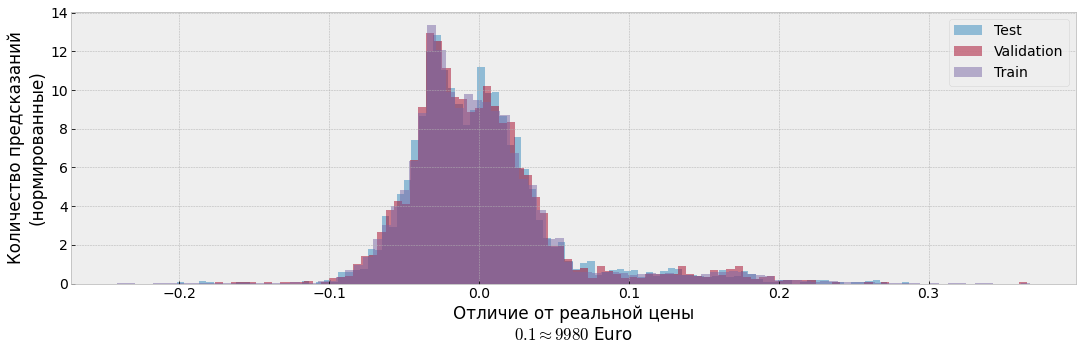

In [ ]:
plt.figure(figsize=(18, 5))
plt.hist(
    data["data_norm_onehot"].iloc[test_idx]["Price(euro)"].values - models_predictions_frame["data_norm_onehot"]["test"],
    bins=100, label="Test", alpha=0.5, density=True
)
plt.hist(
    data["data_norm_onehot"].iloc[val_idx]["Price(euro)"].values - models_predictions_frame["data_norm_onehot"]["val"],
    bins=100, label="Validation", alpha=0.5, density=True
)
plt.hist(
    data["data_norm_onehot"].iloc[train_idx]["Price(euro)"].values - models_predictions_frame["data_norm_onehot"]["train"],
    bins=100, label="Train", alpha=0.5, density=True
)
plt.xlabel("Отличие от реальной цены\n" + r"$0.1 \approx 9980$ Euro")
plt.ylabel("Количество предсказаний\n(нормированные)")
plt.legend(loc="best")
plt.show()

Как видно из гистограммы основная часть предсказаний сконцентрирована в диапозоне $[-0.7, 0.7]$ - что примерно $\pm 7000$ евро. Однако, модель отлично обучилась с точки зрения поведения на `train`, `validation` и `test` - почти идентичные распределения.

> Приведем `предсказания` и `реальные цены` к исходному виду

In [ ]:
# веса для обратного преобразования
scaler = pickle.load(open("./norm_scaler.pkl", "rb"))

In [ ]:
price_frame = pd.DataFrame(
    {
        "True price": (data["data_norm_onehot"].iloc[test_idx]["Price(euro)"] *  scaler[test_idx]).astype(int),
        "Predict price": (models_predictions_frame["data_norm_onehot"]["test"] * scaler[test_idx]).astype(int),
    }
)
print(f"{'r2':4s}: {r2_score(price_frame['True price'], price_frame['Predict price']):12.3f}")
print(f"{'rmse':4s}: {mean_squared_error(price_frame['True price'], price_frame['Predict price'], squared=True):12.3f}")
print(f"{'mse':4s}: {mean_squared_error(price_frame['True price'], price_frame['Predict price'], squared=False):12.3f}")
print(f"{'mean':4s}: {(price_frame['True price'] - price_frame['Predict price']).mean():12.3f}")
print(f"{'std':4s}: {(price_frame['True price'] - price_frame['Predict price']).std():12.3f}")

r2  :        0.452
rmse: 48830818.139
mse :     6987.905
mean:     -550.617
std :     6967.260


С возвращением реального масштаба цен - все встает на свои места: в среднем ошибка $\pm 7000$ евро!

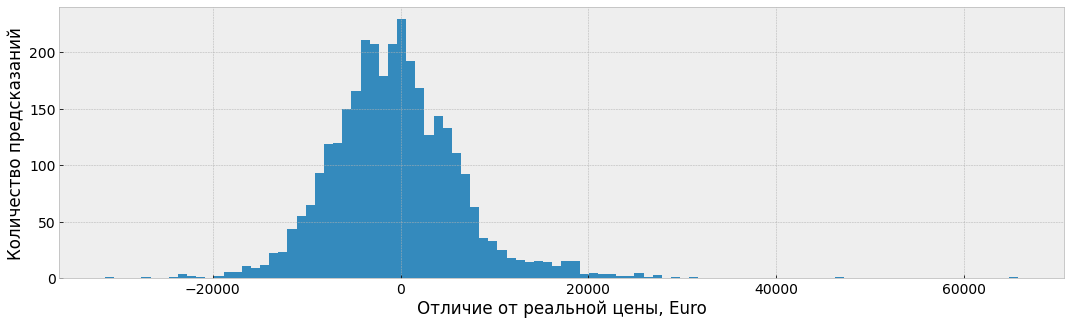

In [ ]:
plt.figure(figsize=(18, 5))
plt.hist(price_frame["True price"] - price_frame["Predict price"], bins=100)
plt.xlabel("Отличие от реальной цены, Euro")
plt.ylabel("Количество предсказаний")
plt.show()

На гистограмме **разность** реальной и предсказанной цены.

**Рассмотрим влияние признаков на финальную оценку цены**

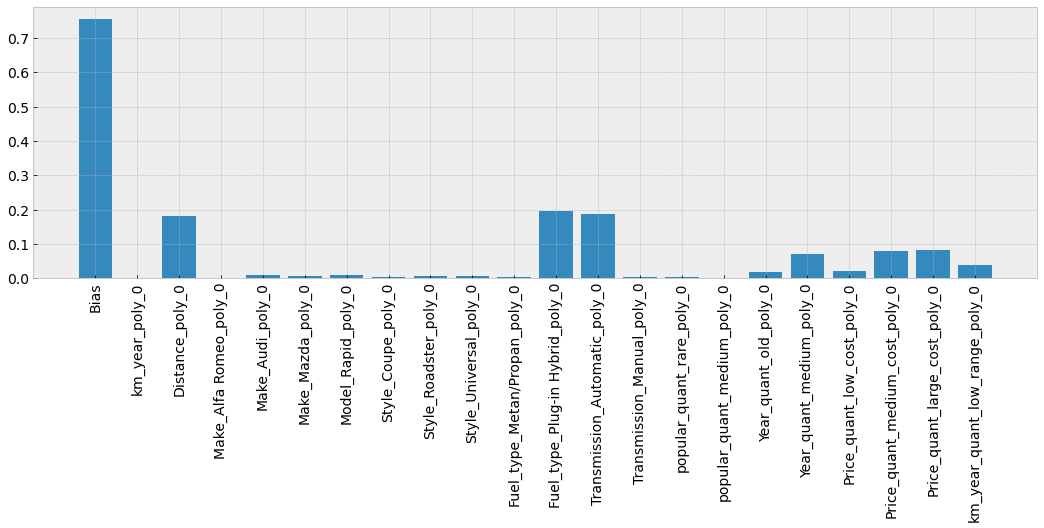

In [ ]:
def decode_weights(data: dict, train_results: dict, model_name: str, w_percentile: int=90) -> dict:

    # get best model results
    best_iter = train_results[model_name]["parameters_table"]["best_val_score"].sort_values(ascending=True).index[0]
    polynom_order = train_results[model_name]["parameters_table"]["polynom_order"].iloc[best]

    restore_weights = lambda w_str: np.array([
        float(x) for x in w_str.replace("\n", " ").replace("[", "").replace("]", "").split(" ") if "" != x
    ])

    best_w = restore_weights(models_predictions_frame[model_name]["parameters_table"]["best_weights"].iloc[best_iter])
    feature_idx = np.where(best_w > np.percentile(best_w, w_percentile))[0]

    # decode all feature names
    if polynom_order is None:
        columns_names = ["Bias"] + list(data[model_name].columns)
    else:
        columns_names = ["Bias"]
        for col in data[model_name].columns:
            for poly in range(polynom_order):
                columns_names += [f"{col}_poly_{poly}"]
    columns_names = np.array(columns_names)

    fig, ax = plt.subplots(1, figsize=(18, 5))
    ax.bar(columns_names[feature_idx.tolist()], best_w[feature_idx.tolist()])
    ax.tick_params(axis='x', labelrotation=90)
    plt.show()

    return

decode_weights(data, models_predictions_frame, "data_norm_onehot")

Веса в целом достаточно хорошо трактуются (взял $\ge90$ перцентиль):
* Основной вес - смещение модели, пока не придумал как его интерпретировать.
* Из характеристик машины: пробег,  тип коробки, тип топлива, год выпуска.
* Из интересного - достаточно большой вес у конкретных моделей (относительно других), что говорит о достаточно стабильной цене (и большом количесве данных автомобилей в датасете).